# Assignment3

Welcome to the third assignment! We're excited to see what you'll create using the techniques you've learned in this course.

First of all, please type your name and UID in the following format:

Firstname Lastname, #UID

In this assignment we will write a Vision Transformer, and use it for classification on Miniplaces, and semantic segmentation on Oxford-IIIT Pets

In [1]:
#@title Your Info { display-mode: "form" }

Name = 'Rishabh Sharma' #@param {type:"string"}
UID = '605983747' #@param {type:"string"}

## Goals
The goals of this assignment are to:

1. Build a Vision Transformer (ViT) from scratch .
2. Build a Semantic Segmentation model using a ViT encoder

By the end of this assignment, you will have gained experience with:

- Working with PyTorch and the MiniPlaces dataset for image classification.
- Implementing and training different types of neural networks using PyTorch.
- Debugging and troubleshooting issues that may arise during the development process.

Please note that it may take some time to run the entire notebook and prepare the submission version. Make sure to allocate enough time for this task and start early. If you have any questions or run into any issues, please feel free to raise them in the Piazza forum or search the internet for debugging purposes. However, please do not directly copy code from other sources.

This assignment is due on ***Sunday, Mar 3rd***.

**Do not use any Code AI to finish the assignment.**


Good luck and happy coding! Remember, the most important thing is to have fun and learn something new.




## Setup Code


To begin, you will need to download the MiniPlaces dataset using the provided link.

-----


Recall the introduction about the storage system of CoLab we went through in the assignment 1. For efficient development of our models, we will still use the temporary storage space to hold our data. This means that every time you open up this notebook, we will need to re-download and process the dataset. Don't worry though - this shouldn't take long, usually just a minute or less. Okay, let's get started!

In [2]:
!pip install einops
# Downloading this file takes about a few seconds.
# Download the tar.gz file from google drive using its file ID.
!pip3 install --upgrade gdown --quiet
!wget https://web.cs.ucla.edu/~smo3/data.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00
--2024-02-28 23:02:01--  https://web.cs.ucla.edu/~smo3/data.tar.gz
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460347416 (439M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 439.02M  44.3MB/s    in 9.8s    

2024-02-28 23:02:11 (44.7 MB/s) - ‘data.tar.gz’ saved [460347416/460347416]



In [3]:
import os
import tarfile
from tqdm import tqdm
import urllib.request

def setup(file_link_dict={},
          folder_name='Assignment3'):
  # Let's make our assignment directory
  CS188_path = './'
  os.makedirs(os.path.join(CS188_path, 'Assignment3', 'data'), exist_ok=True)
  # Now, let's specify the assignment path we will be working with as the root.
  root_dir = os.path.join(CS188_path, 'Assignment3')
  # Open the tar.gz file
  tar = tarfile.open("data.tar.gz", "r:gz")
  # Extract the file "./Assignment3/data" folder
  total_size = sum(f.size for f in tar.getmembers())
  with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
      for member in tar.getmembers():
          tar.extract(member, os.path.join(root_dir, 'data'))
          pbar.update(member.size)
  # Close the tar.gz file
  tar.close()
  # Next, we download the train/val/test txt files:
  for file_name, file_link in file_link_dict.items():
      print(f'Downloding {file_name}.txt from {file_link}')
      urllib.request.urlretrieve(file_link, f'{root_dir}/data/{file_name}.txt')
  return root_dir

In [4]:

val_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt'
train_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt'
root_dir = setup(
    file_link_dict={'train':train_url, 'val':val_url},
    folder_name='Assignment3')

Extracting tar.gz file: 100%|██████████| 566M/566M [00:24<00:00, 23.5MB/s]


Downloding train.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt
Downloding val.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt


### Define the data transform


In [5]:
from torchvision import transforms
import torch

image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
image_net_std = torch.Tensor([0.229, 0.224, 0.225])

# Notice we are resize images to 128x128 instead of 64x64.
data_transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize(image_net_mean, image_net_std),
])


### Define the dataset and dataloader

In [6]:
# You can copy your dataset from Assignment2.
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import os
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class MiniPlaces(Dataset):
    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        self.label_dict = label_dict if label_dict is not None else {}

        with open(f'{root_dir}/{split}.txt', 'r') as f:
            lines = f.readlines()

        for line in lines:
            image_path, label = line.split(' ')
            label = int(label)
            self.filenames.append(image_path)
            self.labels.append(label)
            if split == 'train':
                self.label_dict[label] = image_path.split('/')[-2]

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return len(self.filenames)

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        label = self.labels[idx]
        image_path = self.filenames[idx]
        image = Image.open(os.path.join(self.root_dir, f'images/{image_path}'))
        image = self.transform(image)

        return image, label

### Define the train method

In [7]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

In [8]:
def compute_distances_no_loops(x_train, x_test):
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)

  A = x_train.reshape(num_train,-1)
  B = x_test.reshape(num_test,-1)
  AB2 = A.mm(B.T)*2
  dists = ((A**2).sum(dim = 1).reshape(-1,1) - AB2 + (B**2).sum(dim = 1).reshape(1,-1))**(1/2)
  return dists

def predict_labels(dists, y_train, k=1):
  num_train, num_test = dists.shape
  y_pred = torch.zeros(num_test, dtype=torch.int64)

  values, indices = torch.topk(dists, k, dim=0, largest=False)
  for i in range(indices.shape[1]):
    _, idx = torch.max(y_train[indices[:,i]].bincount(), dim = 0)
    y_pred[i] = idx
  return indices, y_pred

class KnnClassifier:
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train

  def predict(self, x_test, k=1):
    y_test_pred = None

    dists = compute_distances_no_loops(self.x_train, x_test)
    _, y_test_pred =  predict_labels(dists, self.y_train, k)

    return y_test_pred

  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    y_test_pred = self.predict(x_test, k=k)
    num_samples = x_test.shape[0]
    num_correct = (y_test == y_test_pred).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Got {num_correct} / {num_samples} correct; '
           f'accuracy is {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

In [9]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}. Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Using device: cuda. Good to go!


In [11]:
! nvidia-smi

Wed Feb 28 23:02:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Q1: Steps to build a ViT from scratch (60 pts)
Vision Transformer (ViT) is a state-of-the-art neural network architecture for image classification tasks. Unlike traditional convolutional neural networks (CNNs), which have been the standard in computer vision for many years, ViT relies on a self-attention mechanism to extract features from images. This approach has shown to achieve competitive results on various benchmark datasets, while also offering the flexibility to handle tasks that require attention over long-range dependencies in images. ViT has quickly gained popularity in the computer vision community, and has spurred further research into the use of self-attention mechanisms in other areas of deep learning.

You will implement the ViT model on the Miniplaces dataset.

To implement ViT model for image classification, you will need to follow these steps：
1.  Extract feature vectors from the input images using a trainable linear projection layer, which converts the 2D image patches into 1D feature vectors.
2. Positional encoding: Add a learnable positional encoding to each feature vector, which provides spatial information to the model.
3. Transformer encoder: Stack multiple Transformer encoder layers to process the encoded features, which allows the model to learn both local and global interactions between the image patches.
4. Classification head: Add a classification head on top of the final encoded feature vector, which maps the learned representations to the corresponding class labels.
5. Training and evaluation: Train the ViT model using an appropriate optimization algorithm and loss function, and evaluate its performance on the validation and testing sets.

If you are not familiair with ViT model, then you can read our textbook [Transformers for Vision](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html#fig-vit), or review our [discussion slides](https://drive.google.com/file/d/1RKSnE9MOAGBu9T-_2TaBEm4ASF189Fms/view).

### Q1.1: Tokenization (10 pts):
At this step, we need to divide each image into a set of non-overlapping patches, and treat each patch as a token. This is the key step that distinguishes ViT from other computer vision models.

#### Q1.1.1 Tokenize_image Method (5pts)

In [119]:
def tokenize_image(img, patch_size=16, stride=16):
    """
    Tokenize an image into non-overlapping image patches.
    Args:
        img (torch.Tensor): The input image with shape (C, H, W).
        patch_size (int): The size of each patch.
        stride (int): The stride of the sliding window.
    Returns:
        patches (torch.Tensor): The tokenized patches with shape (N, patch_size*patch_size*C).
    """

    C, H, W = img.shape
    patches = []
    ################# Your Implementations #################################
    # Hints: write two for loop to loop over this image
    # Each patch is flattened into a 1-dimensional vector and stacked into a
    # tensor with shape (N, patch_size(H) * patch_size(W) * C), where N is the number of patches.
    # We only consider the case image size can be modulo by the patch_size

    # Additionally, before flattening, remember to permute the patch such that
    # it has shape (patch_size(H), patch_size(W), C)
    for i in range(0, H, stride):
      for j in range(0, W, stride):
        patch = img[:, i:i+patch_size, j:j+patch_size]
        patch = patch.permute(1, 2, 0)
        patch = patch.flatten()
        patches.append(patch)
    patches = torch.stack(patches, dim=0)
    ################# End of your Implementations ##########################
    return patches

In [120]:
# test your implementation of tokenize_image
random_img = torch.rand(3,64,64)
patched_img = tokenize_image(random_img,8,8)

for i in [32,16,8,4,2]:
    out = tokenize_image(random_img,i,i)

    fast_patch = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = i, p2 = i)

    answer = fast_patch(random_img.unsqueeze(0))
    equal = torch.allclose(out,answer.squeeze(0))
    #print('Difference: ', equal)
    if equal:
      print('Good! For patch_size: %d, the output match' %(i))
    else:
      print('Uh-oh! For patch_size: %d, the output are different' %(i))
      break

Good! For patch_size: 32, the output match
Good! For patch_size: 16, the output match
Good! For patch_size: 8, the output match
Good! For patch_size: 4, the output match
Good! For patch_size: 2, the output match


#### Q1.1.2 linear projection layer (5 pts)

At this step, you will need to implement the linear projection linear project layer combined with tokenize operation.

This layer is used to transfer a single image to the image embedding.

In [121]:
class Tokenization_layer(nn.Module):
  def __init__(self, dim, patch_dim,patch_height, patch_width):
    super().__init__()
    """
        Args:
          dim (int): input and output dimension.
          patch_dim(int): falttened vectot dimension for image patch
          patch_height (int): height of one image patch
          patch_weight (int): weight of one image patch

        You can use Pytorch's built-in function and the above Rearrange method.
        Input and output shapes of each layer:
        1) Rerrange the image: (batch_size, channels, H,W) -> (batch_size,N,patch_dim)
        2) Norm Layer1 (LayerNorm): (batch_size,N,patch_dim) -> (batch_size,N,patch_dim)
        3) Linear Projection layer: (batch_size,N,patch_dim) -> (batch_size,N,dim)
        4) Norm Layer2 (LayerNorm): (batch_size,N,dim)-> (batch_size,N,dim)
    """

    self.to_patch = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width)
    self.norm1 = None
    self.fc1 = None
    self.norm2 = None

    ################# Your Implementations #################################
    # Hints: You can use the Rearrange method above to achieve faster patch operation
    # Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width)

    self.norm1 = nn.LayerNorm(patch_dim)
    self.fc1 = nn.Linear(patch_dim, dim)
    self.norm2 = nn.LayerNorm(dim)

    ################# End of your Implementations ##########################

  def forward(self, x):
    """
    Args:
      x (torch.Tensor): input tensor in the shape of (batch_size,C,H,W)
    Return:
      out (torch.Tensor): output patch embedding tensor in the shape of (batch_size,N,dim)

     The input tensor 'x' should pass through the following layers:
     1) self.to_patch: Rerrange image
     2) self.norm1: LayerNorm
     3) self.fc1: Fully-Connected layer
     4) self.norm2: LayerNorm

    """

    out = None
    ################# Your Implementations #################################

    x = self.to_patch(x)
    x = self.norm1(x)
    x = self.fc1(x)
    out = self.norm2(x)

    ################# End of your Implementations ##########################
    return out


### Q1.2 Attention (15 pts):
You will need to follow the steps to implement multi-head attention in this question.
1. **Obtain Q,K,V vectors**: To obtain the Q, K, and V vectors, the input vectors are processed through three distinct single linear layers. In our implementation, we use a single linear layer with 3xD output channels, and then we divide the output into three chunks. We consider the first chunk as the Q vectors, the second chunk as the K vectors, and the last chunk as the V vectors.

2. **Calculate similarity**: Compute the similarity scores between query vectors and a set of key vectors using a dot product.

3. **Apply softmax**: Apply a softmax function to normalize the similarity scores across the key vectors. This creates a probability distribution that represents the relative importance of each key vector with respect to the query vector.

4. **Compute weighted sum**: Compute a weighted sum of the** value vectors**, where the weights are the probability distribution obtained in step 2. This produces a context vector that summarizes the most relevant information from the value vectors with respect to the query vector.

5. **Concatenate output**: The outputs of each head are then concatenated and passed through another linear projection to produce the final output.

For more details, you can read our [textbook](https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html).

In [60]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        """
        Args:
          dim (int): input and output dimension.
          heads (int): number of attention heads.
          dim_head (int): input dimension of each attention head.
          dropout (float): dropout rate for attention and final_linear layer.

        Initialize a attention block.
        You can use Pytorch's built-in function.
        Input and output shapes of each layer:
        1) Define the inner dimension as number of heads* dimension of each head
        2) to_qkv: (batch_size, dim) -> (batch_size,3*inner_dimension)
        3) final_linear: (batch_size, inner_dim) -> (batch_size, dim)
        """

        self.heads = heads
        self.dim_head = dim_head

        self.inner_dim = dim_head *  heads


        self.attend = None
        self.dropout = None
        self.final_linear = None


        # Here, you should define
        # 1) self.to_qkv: (batch_size, dim) -> (batch_size,3*inner_dimension)
        # 2) self.dropout: Dropout layer with ratio defined by dropout variable
        # 3) self.final_linear: (batch_size, inner_dim) -> (batch_size, dim)
        ################# Your Implementations #################################

        self.to_qkv = nn.Linear(dim, 3 * self.inner_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.final_linear = nn.Linear(self.inner_dim, dim)

        ################# End of your Implementations ##########################

    def forward(self, x):
        '''
        Forward pass of the attention block.
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,N,dim).

        The input tensor 'x' should pass through the following layers:
        1) to_qkv: (batch_size,N,dim) -> (batch_size,N,3*inner_dimension)
        2) Divide the ouput of to qkv to q,k,v and then divide them in to n heads
            (batch_size,N,inner_dim) -> (batch_size,N,num_head,head_dim)
        3) Use torch.matmul to get the product of q and k
        4) Divide the above tensor by the squre root of head dimension
        5) Apply softmax and then dropout on the above tensor
        6) Mutiply the above tensor with v to get attention
        7) Concatenate the attentions from multi-heads
            (batch_size,N,num_head,head_dim) -> (batch_size,N,inner_dim)
        8) Pass the output from last step to a fully connected layer
        9) Apply dropout for the last step output
        '''
        out = None

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        ################# Your Implementations #################################
        # Hint you can use :
        #    out = rearrange(out, 'b h n d -> b n (h d)')
        # to concatenate the output from all attention heads
        # This operation will change the tensor shape from (batch_size,N,num_head,head_dim)
        # to  (batch_size,N,inner_dim)

        qk = torch.matmul(q, k.transpose(-1, -2))
        qk = qk * (self.dim_head ** -0.5)
        attn = nn.Softmax(qk, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        out = self.final_linear(out)
        out = self.dropout(out)


        ################# End of your Implementations ##########################
        return out

In [122]:
# You can use this cell to check if the output shape of attention'
for dim in [512,768,1096]:
  test_tensor = torch.rand(2,196,dim)
  att_layer = Attention(dim,8,64,0.4)
  output_tensor = att_layer(test_tensor)
  equal =  test_tensor.shape == output_tensor.shape
  if equal:
    print('Good! For input dim: %d, the output shape is correct' %(dim))
  else:
    print('Uh-oh! For input dim: %d, the output shape is wrong' %(dim))
    break

Good! For input dim: 512, the output shape is correct
Good! For input dim: 768, the output shape is correct
Good! For input dim: 1096, the output shape is correct


The norm layer in Vision Transformer (ViT) is a layer that performs layer normalization on the input. It is typically applied after the Multi-Head Attention (MHA) and the MLP layers in the ViT architecture. The norm layer is used to help the model learn better representations by ensuring that the activations are normalized and centered.

In [123]:
### PreNorm function
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        # keey the residual connection here
        return self.fn(self.norm(x), **kwargs)+x

In [124]:
#You can use
a = PreNorm(768, Attention(768, heads = 8, dim_head = 64, dropout = 0.2))
# to create a combination of layer norm and any other layer
test_tensor = torch.rand(2,196,768)
# you can use the following line to do the forward pass
output_tensor = a(test_tensor)

###Q1.3 PositionwiseFeedForward(5 pt)
You will need to implement the posiotionwiseFeedForward layer in Vision Transformer.

The FFN layer is called "position-wise" because it applies a separate feedforward network to each position in the sequence independently. It consists of two linear transformations with a non-linear activation function in between, typically GELU. The first linear transformation maps the input feature vector from its original dimension to a higher-dimensional space, and the second linear transformation maps it back to the original dimension. The output of the FFN layer is the element-wise sum of the input and the transformed feature vector.

In [125]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, dim, mlp_dim, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        """
         Args:
          dim (int): input and output dimension.
          mlp_dim (int): the output dimension of the first layer.
          dropout (float): dropout rate for both linear layers.

        Initialize an MLP.
        You can use Pytorch's built-in nn.Linear function.
        Input and output sizes of each layer:
          1) fc1: dim, mlp_dim
          2) fc2: mlp_dim, dim
        """

        self.fc1 = None
        self.fc2 = None
        self.dropout = None
        self.activation = nn.GELU()
        ################# Your Implementations #################################

        self.fc1 = nn.Linear(dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, dim)
        self.dropout = nn.Dropout(dropout)

        ################# End of your Implementations ##########################

    def forward(self, x):
        '''
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,N,dim).

        The input tensor 'x' should pass through the following layers:
        1) fc1: (batch_size,N,dim) ->  (batch_size,N,mlp_dim)
        2) Apply activation function
        3) Apply dropout
        3) fc2: (batch_size,N,mlp_dim) -> (batch_size,N,dim)
        4) Apply dropout
        '''

        out = None
        ################# Your Implementations #################################

        out = self.fc1(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)

        ################# End of your Implementations ##########################
        return out

In [126]:
# You can use this cell to check if the output shape of PositionwiseFeedForward
for dim in [512,768,1096]:
  test_tensor = torch.rand(2,196,dim)
  ffn = PositionwiseFeedForward(dim,dim*4,0.1)
  output_tensor = ffn(test_tensor)
  equal =  test_tensor.shape == output_tensor.shape
  if equal:
    print('Good! For input dim: %d, the output shape is correct' %(dim))
  else:
    print('Uh-oh! For input dim: %d, the output shape is wrong' %(dim))
    break

Good! For input dim: 512, the output shape is correct
Good! For input dim: 768, the output shape is correct
Good! For input dim: 1096, the output shape is correct


### Q1.4 TransformerBlock (5pt)
Now you can follow the steps and use above class to implement the standard transformer block as demostrated in the following image.

 <img src="https://web.cs.ucla.edu/~smo3/cs188/assignment3/transformer_block.png"  width="20%" height="40%">

1. Apply Layer-norm to the input tensor
2. Apply the Multi-Head Attention (MHA) layer to the output tensor from step1. The MHA layer takes in the input tensor, and returns the attention scores and the attention output tensor.
3. Add the residual connection to the output of the MHA layer.
4. Apply Layer-norm to output of last step
5. Apply the Position-wise Feedforward Network (FFN) layer to the output of the previous step. The FFN layer takes in the output tensor, and returns the transformed output tensor.
6. Add the residual connection to the output of the FFN layer.

In [127]:
class Transformer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        "Implements Transformer block."
        super().__init__()
        '''
        Args:
          dim (int): input and output dimension.
          heads (int): number of attention heads.
          dim_head (int): input dimension of each attention head.
          mlp_dim (int):
          dropout (float): dropout rate for attention and FFN layers.

        '''
        # Use the PreNorm,Attention and PositionwiseFeedForword class to build your
        # Transformer block
        self.attn = None
        self.ff = None

        ################# Your Implementations #################################

        self.attn = PreNorm(dim, Attention(dim, heads, dim_head, dropout))
        self.ff = PreNorm(dim, PositionwiseFeedForward(dim, mlp_dim, dropout))

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,N,dim).
        """
        ################# Your Implementations #################################

        x = x + self.attn(x)
        x = x + self.ff(x)

        ################# End of your Implementations ##########################
        return x

In [128]:
# You can use this cell to check if the output shape of Transformer
for dim in [512,768,1096]:
  test_tensor = torch.rand(2,196,dim)
  transformer_block = Transformer(dim,8,64,dim*4,0.1)
  output_tensor = transformer_block(test_tensor)
  equal =  test_tensor.shape == output_tensor.shape
  if equal:
    print('Good! For input dim: %d, the output shape is correct' %(dim))
  else:
    print('Uh-oh! For input dim: %d, the output shape is wrong' %(dim))
    break

Good! For input dim: 512, the output shape is correct
Good! For input dim: 768, the output shape is correct
Good! For input dim: 1096, the output shape is correct


###Q1.5 ViTModel (20 pts)
Now you can use above classes to build your Vision Transfromer. Recall the ViT Architecture.

 <img src="https://web.cs.ucla.edu/~smo3/cs188/assignment3/vit.png"  width="40%" height="40%">

 Recall the pipline for Vision Transformer model:

1. Load the input images and preprocess them into a set of image patches. The patches should be non-overlapping and should cover the entire input image. Each patch should be flattened into a vector and projected into a lower-dimensional/equal-dimensional space using a linear layer.

2. Add cls token and learnable positional embeddings to the projected patch vectors. The positional embedding should encode the spatial location of each patch in the input image.

3. Stack several Transformer blocks to process the patch vectors. Each Transformer block should consist of a Multi-Head Attention (MHA) layer and a Position-wise Feedforward Network (FFN) layer, with residual connections and layer normalization applied after each layer.

3. Apply a mean pooling operation over the output of the last Transformer block or take the output vector related to the cls token to obtain a fixed-size feature vector.

5. Feed the feature vector into a fully-connected classification head to predict the class label of the input image.

6. Train the model using a supervised learning objective, such as cross-entropy loss, and backpropagation to update the model weights.

In [129]:
# helper method
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    "Implements Vision Transfromer"
    def __init__(self, *,
                 image_size,
                 patch_size,
                 num_classes,
                 dim,
                 depth,
                 heads,
                 mlp_dim,
                 pool = 'cls',
                 channels = 3,
                 dim_head = 64,
                 dropout = 0.,
                 emb_dropout = 0.,
                ):
        super().__init__()
        """
        Args:
          image_size (int): the height/weight of the input image.
          patch_size (int): image patch size. In the ViT paper, this value is 16.
          num_classes (num_class): Number of image classes for MLP prediction head.
          dim (int): patch and position embedding dimension.
          depth (int): number of stacked transformer blocks.
          heads (int): number of attention heads.
          mlp_dim (int): inner dimension for MLP in transformer blocks.
          pool (str): choice between "cls", "mean", "none".
                      For cls, you will need to use the cls token for perdiction
                      For mean, you will need to take the mean of last transformer output
                      For none, you can just return the last transformer output.
                                This will mainly be used for dense prediction tasks.
          channels (int): Input image channels. Set to 3 for RGB image.
          dropout (float): dropout rate for transformer blocks.
          emb_dropout (float): dropout rate for patch embedding.
        """
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = 0
        patch_dim = 0

        ################# Your Implementations #################################
        # TODO: Compute the num_patches and patch_dim

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = patch_height * patch_width * channels

        ################# End of your Implementations ##########################

        assert pool in {'cls', 'mean', 'none'}, 'pool type must be either cls (cls token), mean (mean pooling), or none (no pooling)'
        self.pool = pool

        self.to_patch_embedding = None

        self.pos_embedding = None
        self.cls_token = None
        self.dropout = None
        self.transformers = nn.ModuleList([])
        self.mlp_head = None
        ################# Your Implementations #################################
        # TODO:
        # 1) Define self.to_patch_embedding usinng the Tokenization_layer class
        # 2) Define learnable 1-D pos_embedding using torch.randn, the number of
        #    embedding should be num_patches+1
        # 3) Define learnable 1-D cls_token with dimension = dim. You can use
        #    nn.Parameter and torch.randn to initialize this
        # 4) Define dropout with emb_dropout
        # 5) Define array of d Transformer modules, where d=depth
        # 6) Using nn.Sqeuential to create the MLP head including two layers:
        #    The first layer in the MLP head is a LayerNorm layer.
        #    The second layer in the MLP head is a linear layer change dimension to num_classes
        #    Note that this MLP head should have 'dim' input dimensions, not 'mlp_dim' which is
        #    used for the MLP in the transformer block instead.

        self.to_patch_embedding = Tokenization_layer(dim, patch_dim, patch_height, patch_width)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformers = nn.ModuleList([
            Transformer(dim=dim, heads=heads, dim_head=dim_head, mlp_dim=mlp_dim, dropout=dropout)
            for _ in range(depth)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        ################# End of your Implementations ##########################


    def forward(self, img):
        '''
        Args:
            img (torch.Tensor): input tensor in the shape of (batch_size,C,H,W).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,num_class).

        The input tensor 'img' should pass through the following layers:
        1) self.to_patch_embedding: (batch_size,C,H,W) -> (batch_size,N,dim)
        2) Using torch.Tensor.repeat to repeat the cls alone batch dimension.
           Then, concatenate with cls token (batch_size,N,dim) -> (batch_size,N+1,dim)
        3) Take sum of patch embedding and position embedding, then apply dropout.
        4) Passing through all the transformer blocks (batch_size,N+1,dim) -> (batch_size,N+1,dim)
        5) If pool is none, simply return the output of (4). Else, proceed to (5).
        5) Use cls token or use pool method to get latent code of batched images
            (batch_size,N+1,dim) -> (batch_size,dim)
        6) Apply MLP head to the output of last step: (batch_size,dim) -> (batch_size,num_class)

        '''
        out = None
        ################# Your Implementations #################################
        b = img.shape[0]
        patches = self.to_patch_embedding(img)
        cls_tokens = self.cls_token.repeat(b, 1, 1)
        x = torch.cat((cls_tokens, patches), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        for transformer in self.transformers:
            x = transformer(x)

        if self.pool == 'none':
          return x

        if self.pool == 'cls':
            x = x[:, 0]
        elif self.pool == 'mean':
            x = x.mean(dim=1)

        out = self.mlp_head(x)

        ################# End of your Implementations ##########################
        return out

Then let's train your ViT model with with cls token as pool policy.

In [130]:
seed_everything(0)

#Define the model, optimizer, and criterion (loss_fn)
model = ViT(image_size = 128,
    patch_size = 16,
    num_classes = 100,
    dim = 192,
    depth = 8,
    heads = 4,
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
           )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,)

criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val',
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:33<00:00, 16.67it/s, loss=3.96]


Validation set: Average loss = 4.0521, Accuracy = 0.0762


Epoch 2/2: 100%|██████████| 1563/1563 [01:34<00:00, 16.56it/s, loss=3.65]


Validation set: Average loss = 3.9000, Accuracy = 0.0932


I got an accuracy of 14.43% using my own implementation. How about you?

Then let's train your ViT model with with average pooling as pool policy.

In [68]:
seed_everything(0)

#Define the model, optimizer, and criterion (loss_fn)
model = ViT(image_size = 128,
    patch_size = 16,
    num_classes = 100,
    dim = 192,
    depth = 8,
    heads = 4,
    pool = 'mean',
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
           )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,)

criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val',
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [01:36<00:00, 16.27it/s, loss=3.86]


Validation set: Average loss = 4.0015, Accuracy = 0.0901


Epoch 2/2: 100%|██████████| 1563/1563 [01:34<00:00, 16.52it/s, loss=3.62]


Validation set: Average loss = 3.8446, Accuracy = 0.1096


I got an accuracy of 14.11% using my own implementation. How about you?

### Q1.6 Comparision bewteen ResNet and ViT (5pts)
Train your resnet18 model without pretrained weighted for 2 epoch, and comparing the accuracy with ViT model.

In [69]:
import torchvision.models as models

# Train your resnet18 model without pretrained weighted for 2 epoch, and comparing the accuracy with ViT model.
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet = models.resnet18(pretrained=False, num_classes=100) # Resnet(pretrained=False)

optimizer = torch.optim.AdamW(
    resnet.parameters(),
    lr=0.0001)


criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val',
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(resnet, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/2: 100%|██████████| 1563/1563 [02:00<00:00, 12.92it/s, loss=3.38]


Validation set: Average loss = 3.1417, Accuracy = 0.2204


Epoch 2/2: 100%|██████████| 1563/1563 [01:56<00:00, 13.41it/s, loss=2.6]


Validation set: Average loss = 2.8243, Accuracy = 0.2906


Use 2-3 sentence, explain the why there is a performance gap between ResNet and ViT when they are trained with a short time.





> ResNet is a CNN architecture, and CNNs are able to learn the spatial features of images, making them better at classification with less data and fewer training iterations. ViTs require self-attention techniques to learn, which means the need more data and more training iterations to learn than CNNs. Thus, when trained a short amount of time, ResNet performs better.

---

## Q2: Using your ViT for Semantic Segmentation (40 pt)

In the previous part, you successfully implemented a ViT for image classification. The next step in this assignment is to use your ViT for dense prediction. Here, we will implement a semantic segmentation model using a pre-trained ViT as an image encoder. We will use the Oxford-IIIT Pet Dataset for this section.

Recall that unlike a typical image classification model, which assigns a single classification label to the entire **image**, the semantic segmentation task assigns a label to every **pixel** of the image.



### Q2.1 Setting up the dataset (10 pt)

First, let's set up the dataset. We will be using one that is provided by PyTorch in the Torchvision package

In [70]:
# Download the dataset containing images and annotations
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2024-02-29 00:04:55--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2024-02-29 00:04:55--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.3MB/s    in 40s     

2024-02-29 00:05:36 (18.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2024-02-29 00:05:36--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [71]:
# Extract images and annotations
os.makedirs(os.path.join(root_dir, 'OxfordPets'), exist_ok=True)
!tar -xzf images.tar.gz -C Assignment3/OxfordPets
!tar -zxf annotations.tar.gz -C Assignment3/OxfordPets

In [72]:
# Let's take a look at what is contained within the downloaded data
print("---- annotations directory ----")
!ls Assignment3/OxfordPets/annotations/
print("\n---- images directory ----")
!ls Assignment3/OxfordPets/images | shuf | head -n 5
print("\n---- trainval.txt file ---")
!head -n 5 Assignment3/OxfordPets/annotations/trainval.txt
print("\n---- test.txt file ---")
!head -n 5 Assignment3/OxfordPets/annotations/test.txt
print("\n---- segmentation map directory ---")
!ls Assignment3/OxfordPets/annotations/trimaps | shuf | head -n 5

---- annotations directory ----
list.txt  README  test.txt  trainval.txt  trimaps  xmls

---- images directory ----
great_pyrenees_112.jpg
english_setter_193.jpg
great_pyrenees_189.jpg
British_Shorthair_10.jpg
american_pit_bull_terrier_190.jpg

---- trainval.txt file ---
Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1

---- test.txt file ---
Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1

---- segmentation map directory ---
newfoundland_61.png
Abyssinian_206.png
Persian_140.png
german_shorthaired_150.png
samoyed_154.png


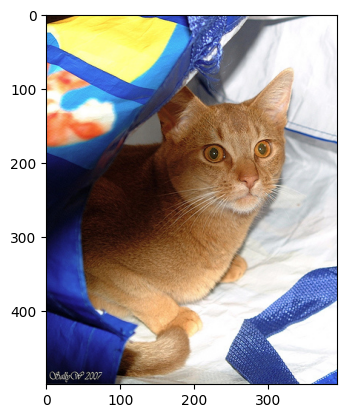

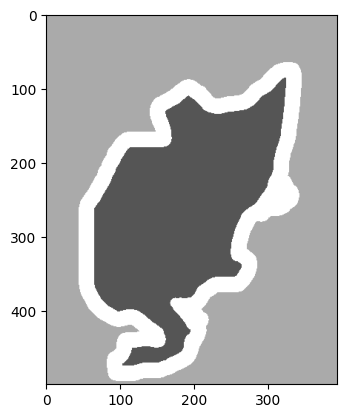

In [73]:
import matplotlib.pyplot as plt

# Lets visualize some of the files
image_vis = Image.open("Assignment3/OxfordPets/images/Abyssinian_100.jpg")
segmap_vis = Image.open("Assignment3/OxfordPets/annotations/trimaps/Abyssinian_100.png")

# Visualize the image and shape
plt.figure()
plt.imshow(image_vis)
plt.figure()
plt.imshow(np.array(segmap_vis) / 3, cmap='gray', vmin=0.0, vmax=1.0)

In [74]:
# Lets take a closer look at the values contained in the segmentation map
print("--- shape ---")
print(np.array(segmap_vis).shape)
print("\n--- contents ---")
print(np.array(segmap_vis))
print("\n--- unique values ---")
print(np.unique(np.array(segmap_vis)))

--- shape ---
(500, 394)

--- contents ---
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]

--- unique values ---
[1 2 3]


After inspecting the segmenetation map, we observe that it is single channel 2D array, with values either 1, 2, or 3.

In the Oxford-IIIT Pets dataset, these values correspond to the labels

1.   Pet
2.   Background
3.   Border


#### Q2.1.1 Define the segmentation dataset (5 pt)

In [83]:
import os
import os.path
import pathlib
from typing import Any, Callable, Optional, Sequence, Tuple, Union

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib.pyplot as plt


class OxfordIIITPetSegmentation(Dataset):
    """`Oxford-IIIT Pet Dataset   <https://www.robots.ox.ac.uk/~vgg/data/pets/>`_.

    Args:
        root (string): Root directory of the dataset.
        split (string, optional): The dataset split, supports ``"trainval"`` (default) or ``"test"``.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed
            version. E.g, ``transforms.RandomCrop``.
        target_transform (callable, optional): A function/transform that takes in the target and transforms it.
    """

    def __init__(
        self,
        root: str,
        split: str = "trainval",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        # Note that this dataset contains train, val, and test sets. For the purpose
        # of this assignment, we will be combining both the train and val datasets
        # for training, and use the test dataset for testing.
        assert split in ["trainval", "test"]

        self.transform = transform
        self.target_transform = target_transform
        self.split = split
        self.root = root

        self.base_folder = pathlib.Path(self.root) / "OxfordPets"
        self.images_folder = self.base_folder / "images"
        self.anns_folder = self.base_folder / "annotations"
        self.segmaps_folder = self.anns_folder / "trimaps"

        self.image_paths = []
        self.segmap_paths = []


        # Here, you will populate the arrays self.image_paths and self.seg_maps
        #
        # Hint: The format of trainval.txt looks like this
        # ---- trainval.txt file ---
        # Abyssinian_100 1 1 1
        # Abyssinian_101 1 1 1
        # ...
        # ---------------------------
        # where the first (space-separated) column of each line corresponds to the image name.
        # You should be able use just this image name alone to populate both the
        # self.image_paths field, and self.seg_maps field!

        ################# Your Implementations #####################################

        with open(os.path.join(self.anns_folder, self.split + ".txt"), 'r') as file:
          for line in file:
            filename =  line.split(" ")[0]
            self.image_paths.append(os.path.join(self.images_folder, filename + ".jpg"))
            self.segmap_paths.append(os.path.join(self.segmaps_folder, filename + ".png"))


        ################# End of your Implementations ##############################


    def __len__(self) -> int:
        return len(self.image_paths)



    def load_segmentation_map_tensor(self, idx):
        # This function should load the segmentation map as a **Long** Tensor, ensuring
        # that the tensor values are in the set {0,1,2}, where
        # 0: Pet, 1: Background, 2: Border
        #
        # The expected shape of the loaded segmentation map should be 1 x H x W
        segmap = None

        ################# Your Implementations #####################################

        segmap = Image.open(self.segmap_paths[idx])
        segmap = transforms.ToTensor()(segmap) * 255
        segmap = segmap.long().squeeze()
        segmap = segmap - 1
        segmap = segmap.unsqueeze(0)

        ################# End of your Implementations ##############################

        return segmap

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        image = Image.open(self.image_paths[idx]).convert("RGB")
        target = self.load_segmentation_map_tensor(idx)

        if self.transform:
          image = self.transform(image)

        if self.target_transform:
          target = self.target_transform(target)

        return image, target

####Q2.1.2 Define data transformations (5 pt)


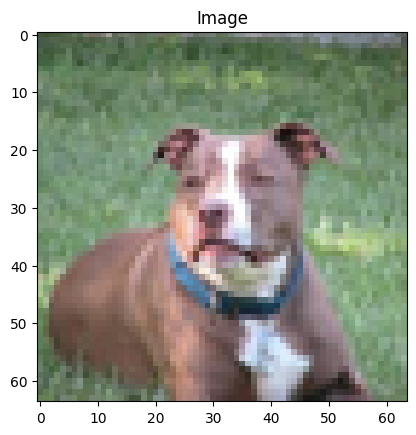

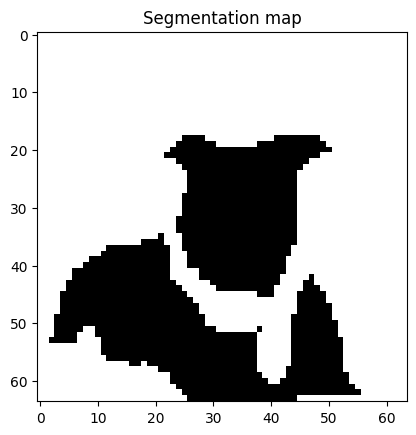

In [85]:
def tensor_to_image(image):
    """
    Convert a tensor image back to a displayable image.

    Args:
        image (torch.Tensor): Tensor image to convert.

    Returns:
        numpy.ndarray: Displayable image.
    """
    tensor_image = image.clone().detach()
    tensor_image = tensor_image.permute(1, 2, 0)
    tensor_image = tensor_image.mul_(image_net_std).add_(image_net_mean)
    numpy_image = tensor_image.numpy()

    return numpy_image

image_transform = None
target_transform = None
normalize = transforms.Normalize(image_net_mean, image_net_std)

# Now, let's define some transformations.
# For the image, you should
# 1.  Resize image such that min(height, width) = 64, while keeping aspect ratio
# 2.  Center crop the resulting image to 3 x 64 x 64
# 3.  Convert to a tensor
# 4.  Normalize using the normalize function defined above

# For the segmentation map, you should
# 1.  Resize image such that min(height, width) = 64, while keeping aspect ratio
# 2.  Center crop the resulting image to 3 x 64 x 64

################# Your Implementations #####################################
# At the end of this function, image_transform and target_transform should be
# updated accordingly.
# Hint: For step 1, transforms.Resize provides a very easy way of doing this
# Hint: Use the NEAREST_EXACT resizing algorithm to make sure values of the
#       segmentation mask are interpolated correctly

image_transform = transforms.Compose([
    transforms.Resize(64, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    normalize,
])

target_transform = transforms.Compose([
    transforms.Resize(64, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.CenterCrop(64),
])


################# End of your Implementations ##############################



train_dataset = OxfordIIITPetSegmentation(root_dir, "trainval", image_transform, target_transform)
val_dataset = OxfordIIITPetSegmentation(root_dir, "test", image_transform, target_transform)

# Let's visualize the dataset!
idx = 139
plt.figure()
plt.imshow(tensor_to_image(train_dataset[idx][0]))
plt.title('Image')
plt.figure()
plt.imshow(train_dataset[idx][1].permute(1, 2, 0).numpy(), cmap='gray', vmin=0.0, vmax=1.0)
plt.title('Segmentation map')

# If your implementation is correct, all these asserts should pass
assert train_dataset[idx][0].shape == (3, 64, 64)
assert train_dataset[idx][1].shape == (1, 64, 64)
assert np.all(np.unique(train_dataset[idx][1]) == np.array([0,1,2]))
assert train_dataset[idx][1].dtype == torch.long

Next, let's define our network. For this exercise, we will be using a ViT as our image encoder, and a simple decoder that consist of a 2-layer convolutional network, followed by bilinear upsampling. This is inspired by the Naive Upsampling decoder used in the Segmentation Transformer model ([Rethinking Semantic Segmentation from a Sequence-to-Sequence Perspective
with Transformers](https://arxiv.org/pdf/2012.15840.pdf))

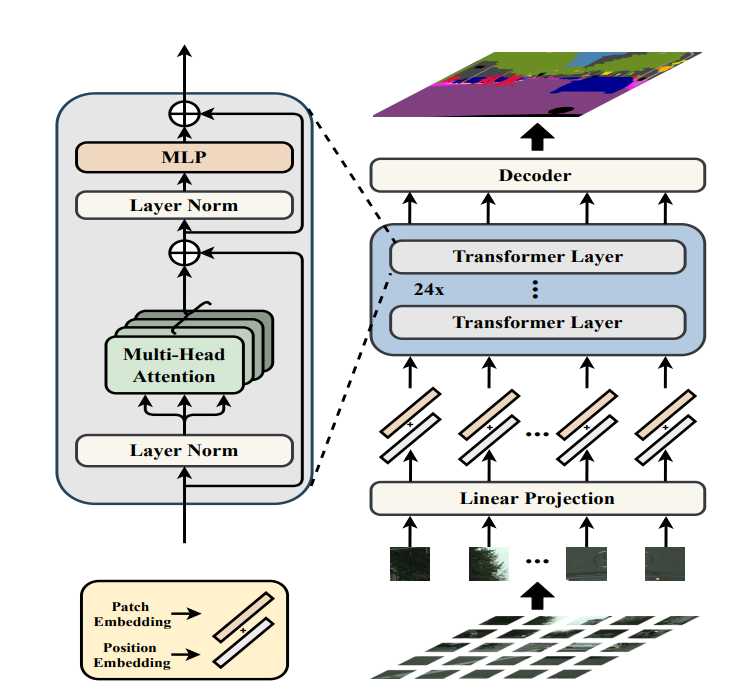

Our decoder will take in the output of the ViT model before the MLP Head that has shape `(B x (N+1) x dim)`, and output a `(B x 1 x H x W)`
segmentation map. Our decoder will work as follows:

1.  Discard the CLS token, resulting in an output shape `(B x N x dim)`. Note that we do not need the CLS token anymore, since it is used primarily image-level statistics (i.e. class of the image). For semantic segmentation, we instead require a prediction for each individual pixel of the image.
2.  Recall that N = Num. of Patches = `(H / patch_size) * (W / patch_size)`, where `H` and `W` are the height and width of the original image respectively. We will reshape the patches into a 2D image of height `H' = H / patch_size` and width `W' = W / patch_size`. The resulting output shape will be `(B x H' x W' x dim)`.
3.  To be able to perform convolution operations, we will permute the resulting tensor to become `(B x dim x H' x W')`.
4.  We will then pass the resulting output through two convolutional layers. The last layer will output a prediction of shape `(B x num_classes x H' x W')`, where `num_classes` corresponds to the number of classes to predict in the final segmentation map.
5.  Remember `H'` and `W'` are of dimension `(H / patch_size)` and `(W / patch_size)` respectively. Since we want an output segmentation map with the same shape as the original image, we will upsample the map to have shape `(B x num_classes x H x W)`, corresponding to the predicted segmentation map.


###Q2.2 Build the Segmentation Model (15 pt)

#### Q2.2.1 Define the segmentation decoder (10 pt)

In [86]:
class MySegmentationDecoder(nn.Module):
    def __init__(self,
                 image_size,
                 patch_size,
                 num_classes,
                 dim):
        super().__init__()
        """
        Args:
          image_size (int): the height/weight of the input image.
          patch_size (int): image patch size. In the ViT paper, this value is 16.
          num_classes (num_class): Number of image classes for MLP prediction head.
          dim (int): patch and position embedding dimension.

        Initialize the semantic segmentation decoder.
        1) Discard CLS token: (B, N+1, dim) -> (B, N, dim)
        2) Reshape output into 2D image with dim channels:
           (B, N, dim) -> (B, dim, H', W') where
            H' := image_size / patch_size
            W' := image_size / patch_size
        3) First 1x1 convolution: (B, dim, H', W') -> (B, dim, H', W')
        4) Apply batch norm + ReLU on the result: (B, dim, H', W') -> (B, dim, H', W')
        5) Second 1x1 convolution: (B, dim, H', W') -> (B, num_classes, H', W')
        6) Upsample: (B, num_classes, H', W') -> (B, num_classes, H, W)
                     where H = W = image_size
        """

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim

        self.conv1 = None
        self.bn1 = None
        self.conv2 = None

        # Here, you should define
        # 1) self.conv1: 1*1 kernel: (B, dim, H', W') -> (B, dim, H', W')
        # 2) self.bn1: 2D Batch Norm: (B, dim, H', W') -> (B, dim, H', W')
        # 3) self.conv2: 1*1 kernel, no bias: (B, dim, H', W') -> (B, num_classes, H', W')
        ################# Your Implementations #################################

        self.conv1 = nn.Conv2d(dim, dim, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(dim)
        self.conv2 = nn.Conv2d(dim, num_classes, kernel_size=1)

        ################# End of your Implementations ##########################

    def forward(self, x):
        '''
        Forward pass of the segmentation decoder.
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N+1,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,num_classes,H,W).

        The input tensor 'x' should pass through the following layers:
        1) Discard CLS token
        2) Reshape to (B, dim, H', W')
        3) Apply first convolution layer
        4) Apply batch norm followed by ReLU activation
        5) Apply second convolution layer
        6) Apply bilinear upsampling (you may use torch.nn.functional.interpolate)
        '''
        out = None

        ################# Your Implementations #################################
        # Hint: you may use
        #     rearrange(x, 'b (h w) d -> b d h w', w=self.image_size // self.patch_size)

        x = x[:, 1:, :]
        x = rearrange(x, 'b (h w) d -> b d h w', w=self.image_size // self.patch_size)

        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)

        out = nn.functional.interpolate(x, size=(self.image_size, self.image_size), mode='bilinear', align_corners=False)

        ################# End of your Implementations ##########################
        return out

Next, we will define the full ViT Segmentation Model using the ViT encoder and the custom decoder implemented above


#### Q2.2.2 Combine the ViT encoder with the Segmentation Decoder (5 pt)

In [87]:
class MyVITSegmentationModel(nn.Module):
  def __init__(self,
               image_size,
               patch_size,
               num_classes,
               dim,
               depth,
               heads,
               mlp_dim,
               channels = 3,
               dim_head = 64,
               dropout = 0.,
               emb_dropout = 0.,
              ):
    super().__init__()
    """
    Args:
      image_size (int): the height/weight of the input image.
      patch_size (int): image patch size. In the ViT paper, this value is 16.
      num_classes (num_class): Number of image classes for MLP prediction head.
      dim (int): patch and position embedding dimension.
      depth (int): number of stacked transformer blocks.
      heads (int): number of attention heads.
      mlp_dim (int): inner dimension for MLP in transformer blocks.
      channels (int): Input image channels. Set to 3 for RGB image.
      dropout (float): dropout rate for transformer blocks.
      emb_dropout (float): dropout rate for patch embedding.
    """

    self.vit_encoder = None
    self.decoder = None

    # Here, you should define
    # 1) self.vit_encoder: Use the parameters in __init__ to initialize the ViT encoder.
    #    Remember to set pool='none' to get the output of the ViT before the MLP head
    # 2) self.decoder: Use the parameters in __init__ to initialize MySegmentationDecoder
    ################# Your Implementations #################################

    self.vit_encoder = ViT(
        image_size=image_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        channels=channels,
        dim_head=dim_head,
        dropout=dropout,
        emb_dropout=emb_dropout,
        pool='none'
    )

    self.decoder = MySegmentationDecoder(
        image_size=image_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=dim
    )

    ################# End of your Implementations ##########################

  def forward(self, x):
    '''
    Forward pass of the segmentation model.
    Args:
        img (torch.Tensor): input tensor in the shape of (batch_size,C,H,W).
    Returns:
        out (torch.Tensor): output segmentation map tensor in the shape of (batch_size,C,H,W).

    The input tensor 'x' should pass through the following layers:
    1) ViT Encoder
    2) MySegmentationDecoder
    '''

    out = None

    # Pass the input through the encoder and decoder
    ################# Your Implementations #################################

    x = self.vit_encoder(x)
    out = self.decoder(x)

    ################# End of your Implementations ##########################
    return out

In [88]:
# You can use this cell to check the output shape of MyVITSegmentationModel
for image_size in [32,64,128]:
  test_tensor = torch.rand(2,3,image_size,image_size)
  target_shape = (2,5,image_size,image_size)
  test_model =  MyVITSegmentationModel(image_size = image_size,
    patch_size = 16,
    num_classes = 5,
    dim = 192,
    depth = 8,
    heads = 4,
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
  )
  output_tensor = test_model(test_tensor)
  equal =  target_shape == output_tensor.shape
  if equal:
    print('Good! For image size: %d, the output shape is correct' %(image_size))
  else:
    print('Uh-oh! For image size: %d, the output shape is wrong' %(image_size))
    break

for patch_size in [4,8,16]:
  test_tensor = torch.rand(2,3,64,64)
  target_shape = (2,10,64,64)
  test_model =  MyVITSegmentationModel(image_size = 64,
    patch_size = patch_size,
    num_classes = 10,
    dim = 192,
    depth = 8,
    heads = 4,
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
  )
  output_tensor = test_model(test_tensor)
  equal =  target_shape == output_tensor.shape
  if equal:
    print('Good! For patch_size: %d, the output shape is correct' %(patch_size))
  else:
    print('Uh-oh! For patch_size: %d, the output shape is wrong' %(patch_size))
    break

Good! For image size: 32, the output shape is correct
Good! For image size: 64, the output shape is correct
Good! For image size: 128, the output shape is correct
Good! For patch_size: 4, the output shape is correct
Good! For patch_size: 8, the output shape is correct
Good! For patch_size: 16, the output shape is correct


### Q2.3 Build the training pipeline (15 pt)



Now, let's define our training and validation script. Our scripts will be mostly the same as before, except we will be using two different metrics for our validation criterion: IoU and Dice Coefficient.

Recall IoU is defined as
$$\frac{TP}{TP + FP + FN}$$
In other words, given two sets $X, Y$, this gives $$\frac{|X \cap Y|}{|X \cup Y|}$$


and the Dice Coefficient (or F1 score) is defined as
$$\frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$
In other words, given two sets $X, Y$, this gives $$\frac{2\cdot|X \cap Y|}{|X| +|Y|}$$

#### Q2.3.2 Defining IoU and DICE metrics (10 pt)

In [101]:
def mean_iou(logits, target):
  """
  Computes the mean iou score given the predicted and target segmentation map.
  Args:
    logits (torch.Tensor): logits tensor in the shape of (num_classes,H,W)
    target (torch.Tensor): tensor of type Long in the shape of (H,W)
    Returns:
        out (float): single scalar quantity representing the mean iou score
  """

  out = None
  eps = 1.0
  # Recall that the IoU score for each class label is computed as
  # intersection (of positive predictions) over union (of positive predictions)
  # Return the mean iou score over all class labels and batch size
  ################# Your Implementations #################################
  # Hint: First, convert the logits (B, 3, H, W) to class predictions (B, H, W)
  # Hint: You can use torch.logical_and (or just simply multiplication),
  #       and torch.logical_or for computing intersections and unions
  # Hint: You can use tensor.item() to extract a scalar from a tensor
  # Hint: Use "eps" to avoid division by zero. Make sure to add eps to both the
  #       numerator and denominator!

  num_classes = logits.shape[0]
  logits = torch.argmax(logits, dim=0)
  ious = []

  for n in range(num_classes):
      pred_class = logits == n
      target_class = target == n
      intersection = torch.logical_and(pred_class, target_class).float().sum()
      union = torch.logical_or(pred_class, target_class).float().sum()
      iou = (intersection + eps) / (union + eps)
      ious.append(iou)

  mean_iou = sum(ious)/len(ious)
  out = mean_iou.item()

  ################# End of your Implementations ##########################
  return out


def dice_coeff(logits, target):
  """
  Computes the dice coefficient (a.k.a. F1 score) given the predicted and target segmentation map.
  Args:
    logits (torch.Tensor): logits tensor in the shape of (num_classes,H,W)
    target (torch.Tensor): tensor of type Long in the shape of (H,W)
  Returns:
    out (float): single scalar quantity representing the dice coefficient score
  """

  out = None
  eps = 1.0

  # Return the mean dice coefficient over all class labels and batch size
  ################# Your Implementations #################################

  num_classes = logits.shape[0]
  logits = torch.argmax(logits, dim=0)
  dice_coeffs = []

  for n in range(num_classes):
      pred_class = logits == n
      target_class = target == n
      intersection = 2 * torch.logical_and(pred_class, target_class).float().sum()
      total = pred_class.sum().item() + target_class.sum().item()
      dice_coeff = (intersection + eps) / (total + eps)
      dice_coeffs.append(dice_coeff)

  mean_dice = sum(dice_coeffs) / len(dice_coeffs)
  out = mean_dice.item()

  ################# End of your Implementations ##########################

  return out

In [102]:
def train_seg(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    """
    Train the segmentation model on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs)

                loss = criterion(logits, labels.squeeze())

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, avg_iou, avg_dice = evaluate_seg(model, val_loader, criterion, device)
        print(f'Validation set: Average loss = {avg_loss:.4f}, Average IoU = {avg_iou:.4f}, Average DICE = {avg_dice:.4f}')


def evaluate_seg(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        total_iou = 0.0
        total_dice = 0.0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels.squeeze())
            total_loss += loss.item()

            for logits_b, labels_b in zip(logits, labels):
              # Compute the iou score
              iou = mean_iou(logits_b, labels_b.squeeze(0))
              total_iou += iou

              # Compute the dice score
              dice = dice_coeff(logits_b, labels_b.squeeze(0))
              total_dice += dice

            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    avg_iou = total_iou / num_samples
    avg_dice = total_dice / num_samples

    return avg_loss, avg_iou, avg_dice

In [103]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyVITSegmentationModel(image_size = 64,
    patch_size = 8,
    num_classes = 3,
    dim = 192,
    depth = 8,
    heads = 4,
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
           )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 32
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train_seg(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 115/115 [00:12<00:00,  9.22it/s, loss=0.795]


Validation set: Average loss = 0.7806, Average IoU = 0.3719, Average DICE = 0.4669


Epoch 2/2: 100%|██████████| 115/115 [00:12<00:00,  9.19it/s, loss=0.73]


Validation set: Average loss = 0.7363, Average IoU = 0.3823, Average DICE = 0.4745


I get a mean validation loss of 0.70, IoU of 0.40, and DICE of 0.49. How about you?

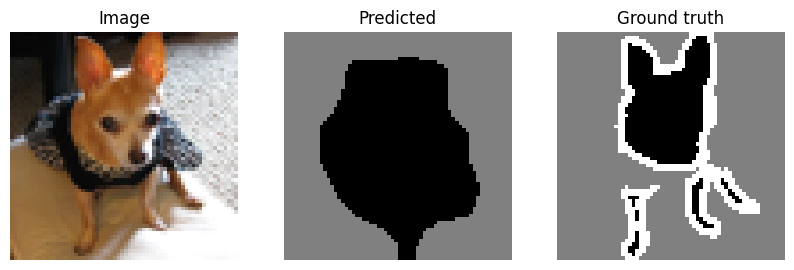

In [112]:
# Let's visualize what our model has predicted!
 #(You can run this cell multiple times to see how your model performs on different inputs)

idx = np.random.randint(0, len(val_dataset)-1)
img, target = val_dataset[idx]
target_vis = target.float().permute(1,2,0).cpu().numpy() / 2
with torch.inference_mode():
  img = img.to(device).unsqueeze(0)
  pred = model(img).squeeze(0).argmax(dim=0)
  pred_vis = pred.float().cpu().numpy() / 2

fig, axs = plt.subplots(1,3, figsize=(10,8))
axs[0].axis("off")
axs[0].imshow(tensor_to_image(img.cpu()[0]))
axs[0].set_title("Image")
axs[1].axis("off")
axs[1].imshow(pred_vis, cmap='gray', vmin=0.0, vmax=1.0)
axs[2].axis("off")
axs[1].set_title("Predicted")
axs[2].imshow(target_vis, cmap='gray', vmin=0.0, vmax=1.0)
axs[2].set_title("Ground truth")
plt.show()

In a few sentences, what is the difference between IoU and DICE score, and why do we need both?

#### Q2.3.2 Question on validation metrics (5 pt)

>We need both metrics because they provide us with different insights on the model's segmentation performance. The IoU is the ratio of the intersection of the predictions and the ground truth to the union of the two and provides the insight of how accurate the segmentation boundary lines are. The Dice Score is ratio of twice the intersection between the predictions and the ground truth to the total number of pixels in both, and places more importance on the size of the segmented objects rather than the exact boundaries.
---

## Q3: Segment Anything - A state-of-the-art semantic segmentation model (0 pts, just for fun)

In this section, we will try out one of the best semantic segmentation models available, and see what it can do!

We will be running [Segment Anything (SAM)](https://segment-anything.com/) by Meta AI. Since it is already pre-trained, we will simply use it for inference. First, let's install it and download the pre-trained Segment Anything model. We will be using the model based on ViT-Huge.

This section will be based off the automatic mask generator class in SegmentAnything, which provides an effective API to generate segmentation masks for an entire image.
This section is inspired by https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [113]:
import os
import torch

# Install the segment anything package
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# Download the pre-trained weights
os.makedirs(os.path.join('./Assignment3', 'SegmentAnything', 'weights'), exist_ok=True)
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P Assignment3/SegmentAnything/weights
weights_path = os.path.join('./Assignment3', 'SegmentAnything', 'weights', "sam_vit_h_4b8939.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



  Preparing metadata (setup.py) ... done


Now that all the setup is done, let's load the model!

In [114]:
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Load the SAM model
sam = sam_model_registry['vit_h'](checkpoint=weights_path).to(device=device)
# Use the automated mask generator class for generating segmentation masks
mask_generator = SamAutomaticMaskGenerator(sam)

Now, let's download in image to use with SAM. A fun activity would be to replace this default image with whatever you choose :)

In [115]:
from PIL import Image
import matplotlib.pyplot as plt

!wget https://s3.amazonaws.com/cms.ipressroom.com/173/files/20198/5d72b4772cfac209ff04c634_Royce+Quad/Royce+Quad_hero.jpg \
-O Assignment3/SegmentAnything/image.jpg

image = Image.open("Assignment3/SegmentAnything/image.jpg")

# Take a look at our image
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Now, let's generate our mask!

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

(as described by https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)

In [116]:
import numpy as np

masks = mask_generator.generate(np.array(image))
# masks now contains a list of segmentation masks, stored in the form of a dictionary
print(type(masks))
print(masks[0].keys())

<class 'list'>
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Let's visualize our segmentations!

In [117]:
# helper function to visualize masks, taken from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [118]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

You can play around with this and segment your own images, have fun!